# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from IPython.display import display
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold


# Import thêm dữ thư viện nếu cần

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu  bằng pandas
train = pd.read_csv('p03.train.csv')
test = pd.read_csv('p03.test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)

X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)



# Sinh viên có thể sử dụng các khác nếu cần



# Cài đặt hàm

In [3]:

def eda_correlation_significance(df, target):
    results = []
    for col in df.columns:
        if col != target:
            r, p = pearsonr(df[col], df[target])
            results.append({
                'Feature': col,
                'Correlation': r,
                'p-value': p
            })
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Correlation', key=abs, ascending=False)
    return results_df

def eda_scatter_features_vs_target(df, target):

    features = [col for col in df.columns if col != target]
    n = len(features)
    
    
    cols = 3  
    rows = (n + cols - 1) // cols  
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  
    
    for i, col in enumerate(features):
        sns.scatterplot(x=df[col], y=df[target], ax=axes[i])
        axes[i].set_title(f"{col} vs {target}")
    
    
    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu

Correlation Significance and p-value:
                            Feature  Correlation        p-value
1                   Previous Scores     0.914775   0.000000e+00
0                     Hours Studied     0.369148  1.320105e-288
3                       Sleep Hours     0.043980   2.996445e-05
4  Sample Question Papers Practiced     0.041088   9.658162e-05
2        Extracurricular Activities     0.025637   1.500931e-02
Scatter plot:


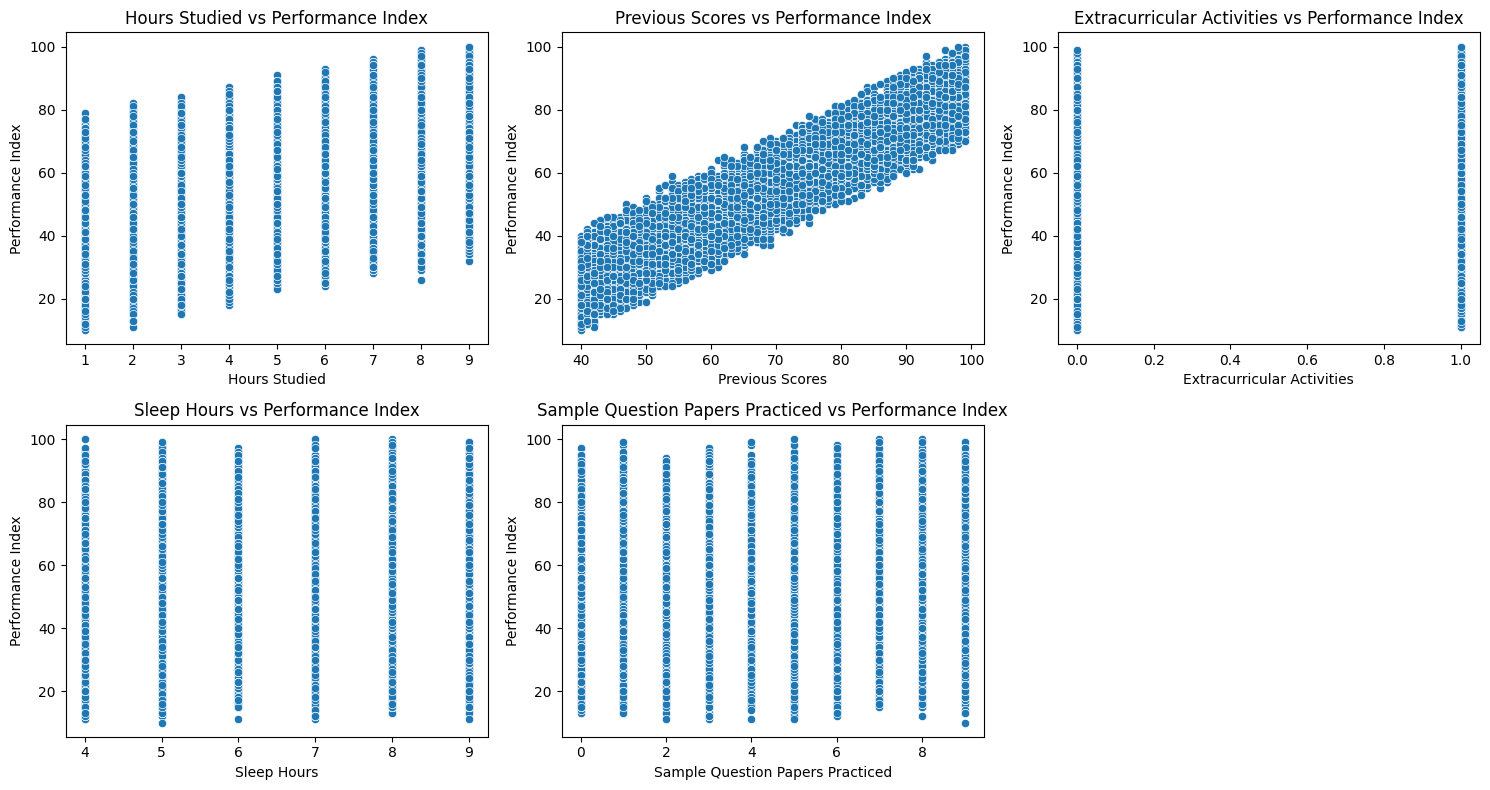

In [4]:
# Phân tích khám phá dữ liệu thông qua thống kê và các biểu đồ
# Chỉ được phân tích trên tập huấn luyện

y_train = y_train.rename('Performance Index')
df_train = pd.concat([X_train, y_train], axis=1)


print('Correlation Significance and p-value:')
cor_sig_df = eda_correlation_significance(df_train, target='Performance Index')
print(cor_sig_df)


print('Scatter plot:')
eda_scatter_features_vs_target(df_train, target='Performance Index')



# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp

In [ ]:
# Phần code cho yêu cầu 2a
class OLSLinearRegression:
    def fit(self, X, y):
        ''' 
        This function is used to fit the model to the data. It uses the Ordinary Least Squares method to find the optimal parameters.

        Parameters
        ----------
        X : np.array
            Input data
        y : np.array
            Output data

        Returns
        -------
        self : object
            Returns the instance of the class
        
        '''

        X_pinv = np.linalg.inv(X.T @ X) @ X.T    # np.linalg.pinv(X)
        self.w = X_pinv @ y

        return self


    def get_params(self):
        ''' 
        This function is used to get the parameters of the model.

        Returns
        -------
        self.w : np.array
            Optimal parameters (column vector)
        '''

        return self.w


    def predict(self, X):
        ''' 
        This function is used to predict the output of the model.

        Parameters
        ----------
        X : np.array
            Input data

        Returns
        -------
        X @ self.w : np.array
            Predicted output
        '''

        return X @ self.w   # Equivalent to np.dot(X, self.w). But why?
    
X_train_bias = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]
model = OLSLinearRegression()
model.fit(X_train_bias, y_train)
weights = np.round(model.get_params(), 3)
print("Trọng số hồi quy:", weights)

Trọng số hồi quy: [-33.969   2.852   1.018   0.604   0.474   0.192]


In [6]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
y_pred = model.predict(X_test_bias)

# Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE trên tập kiểm tra:", np.round(mae, 3))

MAE trên tập kiểm tra: 1.596


Công thức hồi quy, phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -33.969 + 2.852*Hours Studied + 1.018*Previous Scores \\+ 0.604*Extracurricular Activities + 0.474*Sleep Hours + 0.192*Sample Question Papers Practiced

# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [7]:
# Phần code cho yêu cầu 2b
# Tìm ra đặc trưng tốt nhất (trong 5 đặc trưng)
# In ra các kết quả cross-validation như yêu cầu
def evaluate_model(X, y, kf):
    """Tính MAE trung bình qua KFold cho mô hình"""
    mae_scores = []
    # Thêm bias
    X_bias = np.c_[np.ones(X.shape[0]), X]
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_bias), start=1):
        X_tr, X_val = X_bias[train_idx], X_bias[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = OLSLinearRegression().fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_val_pred)
        mae_scores.append(mae)

        print(f"  Fold {fold}: MAE = {mae:.3f}")
    
    return np.mean(mae_scores)


# -------- SỬ DỤNG evaluate_model --------
features = [
    "Hours Studied",
    "Previous Scores",
    "Extracurricular Activities",
    "Sleep Hours",
    "Sample Question Papers Practiced"
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_feature = None
best_mae = float("inf")

y_train_2b = train.iloc[:, -1].values  # Cột target

for feature in features:
    X_train_2b = train[[feature]].values

    avg_mae = evaluate_model(X_train_2b, y_train_2b, kf)
    print(f"{feature}: MAE trung bình = {avg_mae:.3f}\n")

    if avg_mae < best_mae:
        best_mae = avg_mae
        best_feature = feature

print(f"Best feature: {best_feature} với MAE = {best_mae:.3f}")


  Fold 1: MAE = 15.540
  Fold 2: MAE = 15.481
  Fold 3: MAE = 15.487
  Fold 4: MAE = 15.208
  Fold 5: MAE = 15.527
Hours Studied: MAE trung bình = 15.449

  Fold 1: MAE = 6.573
  Fold 2: MAE = 6.598
  Fold 3: MAE = 6.836
  Fold 4: MAE = 6.522
  Fold 5: MAE = 6.561
Previous Scores: MAE trung bình = 6.618

  Fold 1: MAE = 16.409
  Fold 2: MAE = 16.045
  Fold 3: MAE = 16.313
  Fold 4: MAE = 16.021
  Fold 5: MAE = 16.191
Extracurricular Activities: MAE trung bình = 16.196

  Fold 1: MAE = 16.388
  Fold 2: MAE = 16.047
  Fold 3: MAE = 16.286
  Fold 4: MAE = 16.001
  Fold 5: MAE = 16.213
Sleep Hours: MAE trung bình = 16.187

  Fold 1: MAE = 16.378
  Fold 2: MAE = 16.012
  Fold 3: MAE = 16.307
  Fold 4: MAE = 16.051
  Fold 5: MAE = 16.194
Sample Question Papers Practiced: MAE trung bình = 16.188

Best feature: Previous Scores với MAE = 6.618


In [8]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện

X_train_best = train[[best_feature]].values
y_train_best = train.iloc[:, -1].values
X_train_best_bias = np.c_[np.ones(X_train_best.shape[0]), X_train_best]

best_feature_model = OLSLinearRegression().fit(X_train_best_bias, y_train_best)
weights_best_feature_2b = np.round(best_feature_model.get_params(), 3)
print("Trọng số hồi quy:", weights_best_feature_2b)

Trọng số hồi quy: [-14.989   1.011]


Công thức hồi quy (dựa trên mô hình đặc trưng tốt nhất), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = -14.989 + 1.011*PreviousScores

# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất

## Xây dựng/Thiết kế mô hình

In [9]:
# Trình bày toàn bộ code liên quan đến việc thiết kế mô hình



print("Mô hình 1: 2 đặc trưng (Hours Studied, Previous Scores)")
X_model1 = train[["Hours Studied", "Previous Scores"]].values
X_model1_bias = np.c_[np.ones(X_model1.shape[0]), X_model1]
model1 = OLSLinearRegression().fit(X_model1_bias, y_train)
weights_model1 = np.round(model1.get_params(), 3)
print("  Trọng số hồi quy mô hình 1:", weights_model1)

# ===== MÔ HÌNH 2 =====
print("Mô hình 2: Bình phương Previous Scores")
X_model2 = train[["Previous Scores"]].values ** 2
X_model2_bias = np.c_[np.ones(X_model2.shape[0]), X_model2]
model2 = OLSLinearRegression().fit(X_model2_bias, y_train)
weights_model2 = np.round(model2.get_params(), 3)
print("  Trọng số hồi quy mô hình 2:", weights_model2, 3)

# ===== MÔ HÌNH 3 =====
print("Mô hình 3: (PreviousScores^2) * ln2(HoursStudied)")
X_prev_sq = train[["Previous Scores"]].values ** 2
X_hours_ln2 = np.log2(train[["Hours Studied"]].values)
X_model3 = (X_prev_sq * X_hours_ln2)
X_model3_bias = np.c_[np.ones(X_model3.shape[0]), X_model3]
model3 = OLSLinearRegression().fit(X_model3_bias, y_train)
weights_model3 = np.round(model3.get_params(), 3)
print("  Trọng số hồi quy mô hình 3:", weights_model3)



Mô hình 1: 2 đặc trưng (Hours Studied, Previous Scores)
  Trọng số hồi quy mô hình 1: [-29.747   2.856   1.018]
Mô hình 2: Bình phương Previous Scores
  Trọng số hồi quy mô hình 2: [1.8364e+01 7.0000e-03] 3
Mô hình 3: (PreviousScores^2) * ln2(HoursStudied)
  Trọng số hồi quy mô hình 3: [3.2438e+01 2.0000e-03]


## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

In [10]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu
def evaluate_model(X, y, kf):
    """Tính MAE trung bình qua KFold cho mô hình"""
    mae_scores = []
    # Thêm bias
    X_bias = np.c_[np.ones(X.shape[0]), X]
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_bias), start=1):
        X_tr, X_val = X_bias[train_idx], X_bias[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = OLSLinearRegression().fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_val_pred)
        mae_scores.append(mae)

        print(f"  Fold {fold}: MAE = {mae:.3f}")
    
    return np.mean(mae_scores)

# ===== MÔ HÌNH 1 =====
print("Mô hình 1: 2 đặc trưng (Previous Scores, Hours Studied)")
mae_model1 = evaluate_model(X_model1, y_train, kf)
print(f"MAE trung bình Mô hình 1 = {mae_model1:.3f}\n")

# ===== MÔ HÌNH 2 =====
print("Mô hình 2: Bình phương Previous Scores")
mae_model2 = evaluate_model(X_model2, y_train, kf)
print(f"MAE trung bình Mô hình 2 = {mae_model2:.3f}\n")

# ===== MÔ HÌNH 3 =====
print("Mô hình 3: (PreviousScores^2) * ln2(HoursStudied)")
mae_model3 = evaluate_model(X_model3, y_train, kf)
print(f"MAE trung bình Mô hình 3 = {mae_model3:.3f}\n")









Mô hình 1: 2 đặc trưng (Previous Scores, Hours Studied)
  Fold 1: MAE = 1.823
  Fold 2: MAE = 1.791
  Fold 3: MAE = 1.860
  Fold 4: MAE = 1.835
  Fold 5: MAE = 1.772
MAE trung bình Mô hình 1 = 1.816

Mô hình 2: Bình phương Previous Scores
  Fold 1: MAE = 6.699
  Fold 2: MAE = 6.694
  Fold 3: MAE = 7.052
  Fold 4: MAE = 6.692
  Fold 5: MAE = 6.697
MAE trung bình Mô hình 2 = 6.767

Mô hình 3: (PreviousScores^2) * ln2(HoursStudied)
  Fold 1: MAE = 7.034
  Fold 2: MAE = 7.104
  Fold 3: MAE = 7.015
  Fold 4: MAE = 6.802
  Fold 5: MAE = 7.120
MAE trung bình Mô hình 3 = 7.015



In [11]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
best_mae = min(mae_model1, mae_model2, mae_model3)

if best_mae == mae_model1:
    best_model_name = "Model 1"
    X_best = X_model1
elif best_mae == mae_model2:
    best_model_name = "Model 2"
    X_best = X_model2
else:
    best_model_name = "Model 3"
    X_best = X_model3

print(f"➡ Mô hình tốt nhất: {best_model_name}")

# Thêm bias và huấn luyện lại trên toàn bộ tập huấn luyện
X_best_bias = np.c_[np.ones(X_best.shape[0]), X_best]
my_best_model = OLSLinearRegression().fit(X_best_bias, y_train)
weights_my_best_model = np.round(my_best_model.get_params(), 3)
print("Trọng số hồi quy:", weights_my_best_model)

➡ Mô hình tốt nhất: Model 1
Trọng số hồi quy: [-29.747   2.856   1.018]


In [12]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model


if best_model_name == "Model 1":
    X_test_best = test[["Hours Studied", "Previous Scores"]].values
elif best_model_name == "Model 2":
    X_test_best = test[["Previous Scores"]].values ** 2
else:  # Model 3
    X_prev_sq_test = test[["Previous Scores"]].values ** 2
    X_hours_ln2_test = np.log2(test[["Hours Studied"]].values)
    X_test_best = X_prev_sq_test * X_hours_ln2_test

X_test_best_bias = np.c_[np.ones(X_test_best.shape[0]), X_test_best]

# Dự đoán và tính MAE trên tập test
y_test_pred = my_best_model.predict(X_test_best_bias)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"MAE trên tập kiểm tra (test) với {best_model_name} = {test_mae:.3f}")

MAE trên tập kiểm tra (test) với Model 1 = 1.839


Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

$$\text{Student Performance} = − 29.747 + 2.856 × 𝐻𝑜𝑢𝑟𝑠𝑆𝑡𝑢𝑑𝑖𝑒𝑑 + 1.018 × 𝑃𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑆𝑐𝑜𝑟e